In [1]:
import sqlite3
import pandas as pd
import nltk
import datetime
import re

pd.set_option('display.width', 1000)
# plot within the notebook
%pylab inline 

#/Library/Application Support/MobileSync/Backup/d68a00b1faac8ed4cab3d6bec36ea7b05d284ddd
# Read about getting this file here: http://osxdaily.com/2010/07/08/read-iphone-sms-backup/

# connect to the text messages db file.
conn = sqlite3.connect('3d0d7e5fb2ce288813306e4d4636395e047a3d28')
c = conn.cursor()


def getMessageDF():
    ''' get all messages from the message table.
        return a pandas dataframe.'''
    message_table_cols = ['guid', 'service',
                          'text', 'date', 
                          'date_delivered', 
                          'handle_id', 'type', 
                          'is_read','is_sent',
                          'is_delivered','item_type',
                          'group_title']
    message_table_cols_str = ','.join(map(str, message_table_cols))
    res = c.execute("SELECT %s FROM message" % message_table_cols_str)
    message_df = pd.DataFrame(res.fetchall())
    message_df.columns = message_table_cols
    return message_df

message_df = getMessageDF()

Populating the interactive namespace from numpy and matplotlib


In [9]:
## WRANGLE THE DATA AND CATEGORIZE IT ##

# turn all messages into a list, and then convert it to a giant str corpus. 
ALL_MESSAGES_LIST = message_df.text.tolist()
ALL_MESSAGES_STR= ','.join([x.lower() for x in ALL_MESSAGES_LIST if x is not None]) 

def  getTokensAndPOS():
    ''' for all messages, grouped as a single str,
        get the tokens and the parts of speech of each word'''
    tokens = nltk.word_tokenize(ALL_MESSAGES_STR)
    #TODO: fix count of tokens.
    pos_tags = nltk.pos_tag(tokens)

    return tokens, pos_tags

tokens, pos_tags = getTokensAndPOS()

def getMasterWords():
    '''get the list of master words to perform the analysis on'''

    # parts_of_speech that we don't care about because they're kind of boring.
    dont_care_about = ['IN','CC','DT','RB']

    # remove boring stuff.
    for index, item in enumerate(pos_tags):
        if item[1] in dont_care_about:
            pos_tags.pop(index)

    # assemble word list from POS list. take words where word > 2 characters
    word_list = [tag[0] for tag in pos_tags if len(tag[0]) > 2]
    master_words_tuple = nltk.FreqDist(word_list).most_common()
    return master_words_tuple

master_words_tuple = getMasterWords()

## CREATE MASTER WORDS DATAFRAME. ##
# create a dataframe with the master_words_tuple. the tuple included the frequency it was used.
master_words_set_df = pd.DataFrame(master_words_tuple,columns=['word','count_times'])
master_words_set_df['bad_word'] = master_words_set_df.word.apply(lambda x: 1 if x in bad_words_df.word.tolist() else 0)
master_words_set_df['pct_of_total'] = (master_words_set_df.count_times / len(master_words_set_df)) * 100

In [10]:
### GENERAL DATASET INFO ###
print "Total text messages in dataset: {}".format(len(message_df.text))
print "Total words before filtering: {}".format(len(pos_tags))
print "Total words after filtering: {}".format(len(master_words_tuple))

Total text messages in dataset: 65378
Total words before filtering: 8446
Total words after filtering: 1776


In [11]:
### BAD WORDS ANALYSIS ###
with open('bad_words.txt', 'r') as f:
    bad_word_list = f.readlines()
    bad_word_list = [word.strip('\n') for word in bad_word_list]

used_bad_words = []
for entry in master_words_tuple:
    if entry[0] in bad_word_list:
        used_bad_words.append(entry)

# bad words dataframe 
bad_words_df = pd.DataFrame(used_bad_words, columns=['word','count_times'])
bad_words_df['pct_of_total'] = (bad_words_df.count_times / len(pos_tags)) * 100

In [1]:
# plot top 20 bad words. uncomment this !
#bad_words_df[:20].plot(kind='barh', x='word',figsize=(10,5))

In [2]:
# slice the master dataframe by bad words. uncomment this!
#master_words_set_df[master_words_set_df.bad_word==1].head()

In [15]:
## PARTS OF SPEECH ANALYSIS ##
pos_dict = dict(pos_tags)

master_words_set_df['pos'] = master_words_set_df.word.apply(lambda x: pos_dict[x])

# create a mapping dictionary so we know what we are reading!
POS_MAP_DICT = {'CC': ' conjunction, coordinating',
                'CD': ' numeral, cardinal',
                'DT': ' determiner',
                'EX': ' existential there',
                'FW': ' foreign word',
                'IN': ' preposition or conjunction, subordinating',
                'JJ': ' adjective or numeral, ordinal',
                'JJR': ' adjective, comparative',
                'JJS': ' adjective, superlative',
                'LS': ' list item marker',
                'MD': ' modal auxiliary',
                'NN': ' noun, common, singular or mass',
                'NNP': ' noun, proper, singular',
                'NNPS': ' noun, proper, plural',
                'NNS': ' noun, common, plural',
                'PDT': ' pre-determiner',
                'POS': ' genitive marker',
                'PRP': ' pronoun, personal',
                'PRP$': ' pronoun, possessive',
                'RB': ' adverb',
                'RBR': ' adverb, comparative',
                'RBS': ' adverb, superlative',
                'RP': ' particle',
                'SYM': ' symbol',
                'TO': ' "to" as preposition or infinitive marker',
                'UH': ' interjection',
                'VB': ' verb, base form',
                'VBD': ' verb, past tense',
                'VBG': ' verb, present participle or gerund',
                'VBN': ' verb, past participle',
                'VBP': ' verb, present tense, not 3rd person singular',
                'VBZ': ' verb, present tense, 3rd person singular',
                'WDT': ' WH-determiner',
                'WP': ' WH-pronoun',
                'WP$': ' WH-pronoun, possessive',
                'WRB': ' Wh-adverb'}

In [16]:
master_words_set_df['pos_map'] = master_words_set_df.pos.apply(lambda x: POS_MAP_DICT[x] if x in POS_MAP_DICT else None)

In [17]:
# get a dataframe with the counts of each part of speech
pos_count_df = master_words_set_df.groupby(['pos_map'])\
                                    .agg({'pos_map':len})\
                                    .rename(columns={'pos_map':'pos_count'})\
                                    .sort('pos_count', ascending=False)
pos_count_df.head()

,pos_count
pos_map,
"noun, common, singular or mass",765
"adjective or numeral, ordinal",211
"noun, common, plural",183
"verb, present participle or gerund",124
"verb, base form",84


In [18]:
## MESSAGE-BASED ANALYSIS. ##
# information about the messages, their length, is_read, etc.

# create conversion functions for the unix timestamps, which is the format stored in the SQLlite file.

def getHumanReadableDateTime(unix_timestamp):
    '''get human readable datetime from unix timestamp'''
    return datetime.datetime.fromtimestamp(int(unix_timestamp)).strftime('%Y-%m-%d %H:%M:%S')

def getHumanReadableDate(unix_timestamp):
    '''get human readable date from unix timestamp'''
    return datetime.datetime.fromtimestamp(int(unix_timestamp)).strftime('%Y-%m-%d')

In [19]:
# prepend a "1" to all date timestamps to make it a unix timestamp.
# doesn't seem to yield correct results always, though.
message_df['date'] = message_df.date.apply(lambda x: '1'+str(x))

In [20]:
message_df['datetime_readable'] = message_df.date.apply(getHumanReadableDateTime).astype('datetime64[ns]')
message_df['date_readable'] = message_df.date.apply(getHumanReadableDate).astype('datetime64')

In [3]:
message_df.head()

NameError: name 'message_df' is not defined

In [22]:
# create a dataframe that counts the number of texts sent per day
texts_per_day_df = message_df.groupby(['date_readable'])\
                             .agg({'text':len})\
                             .rename(columns={'text':'count_of_texts'})

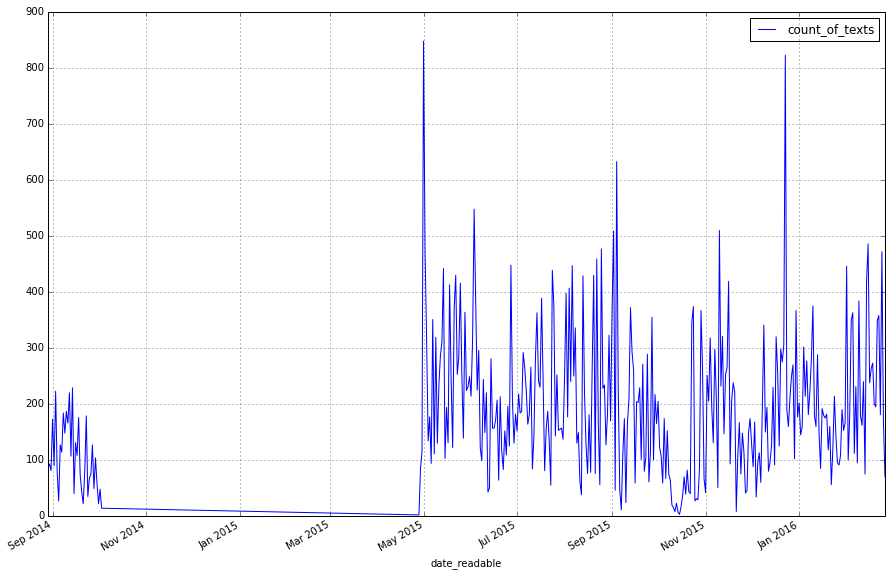

In [23]:
texts_per_day_df.plot(kind='line', figsize=(15,10))

In [26]:
# Sent Versus Unsent. you sent is is_sent=1, you received is is_sent=0
pd.DataFrame(message_df.is_sent.value_counts(), columns=['count_of_messages'])

,count_of_messages
1,33052
0,32326


In [28]:
# Get the Number of Words in Each Text Message
message_df['message_length'] = message_df.text.apply(lambda x: len(re.findall(r"[\w']+", x)) if x is not None else 0)

In [32]:
# AVERAGE MESSAGE LENGTHS
sent_msg_length_mean = message_df[message_df.is_sent==1].message_length.mean()
received_msg_length_mean = message_df[message_df.is_sent==0].message_length.mean()
print "The average length of messages I sent was {}".format(sent_msg_length_mean)
print "The average length of messages I received was {}".format(received_msg_length_mean)

The average length of messages I sent was 5.06277986204
The average length of messages I received was 5.36868155664


In [65]:
## Fields I found were useless: ##
# country. message_df.country.unique(). array([None], dtype=object)
# is_emote. message_df.is_emote.unique(). everything was array([0])
# message_source. message_df.message_source.unique(). everything was array([0])
# share_status: message_df.share_status.value_counts(). {0:46890,1:4}

## Fields that were useful ##
    # text. the message content from the text message.
    # group_title. if you use groups, this is the assigned title of the group.